## Setup Imports

In [1]:
# %pip install tensorflow
%pip install tensorflow-metal
%pip install tensorflow-macos
%pip install pandas
%pip install numpy
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np

## Create RNN

In [3]:
def build_rnn_model(features, max_vocab, max_tokens, embedding_dim):
    """Builds an RNN model"""
    
    # tf.keras.backend.clear_session()
    # tf.keras.utils.set_random_seed(0)

    # Uses Sequential api with guidance from the tutorial https://www.tensorflow.org/text/tutorials/text_classification_rnn
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(3001,), name='Input_Layer'))
    model.add(tf.keras.layers.Embedding(
        input_dim=max_vocab,
        output_dim=embedding_dim,
        input_length=max_tokens,
        name='Embeddings_Layer',
    ))

    # bidirectional layers
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences= True), name='Bidirectional_Layer_1'))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True ), name='Bidirectional_Layer_2'))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64), name='Bidirectional_Layer_3'))

    # hidden sigmoid layers
    model.add(tf.keras.layers.Dense(128, activation='sigmoid', name='hidden_layer_1'))
    model.add(tf.keras.layers.Dense(64, activation='sigmoid', name='hidden_layer_2'))

    # output layers
    model.add(tf.keras.layers.Dense(
        units=1,
        activation='sigmoid',
        name='Output_Layer',
    ))


    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

## Read and Parse Data for Model

In [4]:
emails_df = pd.read_csv('emails.csv')
emails_df.reindex(np.random.permutation(len(emails_df)))
display(emails_df.head())

,Email No.,the,to,ect,and,for,of,a,you,hou,...,connevey,jay,valued,lay,infrastructure,military,allowing,ff,dry,Prediction
0,Email 1,0,0,1,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Email 2,8,13,24,6,6,2,102,1,27,...,0,0,0,0,0,0,0,1,0,0
2,Email 3,0,0,1,0,0,0,8,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Email 4,0,5,22,0,5,1,51,2,10,...,0,0,0,0,0,0,0,0,0,0
4,Email 5,7,6,17,1,5,2,57,0,9,...,0,0,0,0,0,0,0,1,0,0


In [5]:
email_words = list(emails_df.columns)[1:-1] + ['#OOV#']
print(f'{len(email_words)} words in the bags of words')
# display(email_words)

3001 words in the bags of words


In [6]:
reverse_email_words = {}
for index, word in enumerate(email_words):
    reverse_email_words[word] = index

In [7]:
from collections import defaultdict

def prompt_to_np(prompt, debug=False):
    word_tracker = defaultdict(int)
    for word in prompt.split(' '):
        if word in reverse_email_words:
            word_tracker[word] += 1
        else:
            word_tracker['#OOV#'] += 1

    if debug:
        display(word_tracker)

    res = np.zeros((len(email_words)),)

    for word, count in word_tracker.items():
        res[reverse_email_words[word]] = count
    return res

In [8]:
example_prompt = 'Get your free **vbucks** at this link: https://fake.test/'
prompt_to_np(example_prompt, debug=True)


defaultdict(int, {'#OOV#': 4, 'your': 1, 'free': 1, 'at': 1, 'this': 1})

array([0., 0., 0., ..., 0., 0., 4.])

In [9]:
def process_df(df, debug=False):
    words_df = df.loc[:,email_words[:-1]]
    words_df.loc[:,'#OOV#'] = 0
    if debug:
        display(words_df.head())
    return words_df.to_numpy()

In [10]:
emails_np = process_df(emails_df)
actual_np = emails_df[['Prediction']].to_numpy()
display(emails_np)
display(emails_np.shape)
display(actual_np)
display(actual_np.shape)

array([[ 0,  0,  1, ...,  0,  0,  0],
       [ 8, 13, 24, ...,  1,  0,  0],
       [ 0,  0,  1, ...,  0,  0,  0],
       ...,
       [ 0,  0,  1, ...,  0,  0,  0],
       [ 2,  7,  1, ...,  1,  0,  0],
       [22, 24,  5, ...,  0,  0,  0]])

(5172, 3001)

array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [0]])

(5172, 1)

In [11]:
model = build_rnn_model(emails_np, 3001, 100, 9)

2024-05-06 21:29:15.237999: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2024-05-06 21:29:15.238015: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-05-06 21:29:15.238021: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-05-06 21:29:15.238046: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-06 21:29:15.238060: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [12]:
# num_of_epochs=16
num_of_epochs=32
num_per_batch=64
validation=0.3
history = model.fit(
        emails_np,
        actual_np,
        epochs=num_of_epochs,
        batch_size=num_per_batch,
        validation_split=validation,
        verbose=1,
)

Epoch 1/32


2024-05-06 21:29:17.841317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-06 21:29:18.369344: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-06 21:29:18.386029: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-06 21:29:18.577577: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-06 21:29:18.596411: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-06 21:29:18.783469: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-06 21:29:18.798974: I tensorflow/core/grappler/optimizers/cust

57/57 [==============================] - ETA: 0s - loss: 0.6043 - accuracy: 0.7028

2024-05-06 21:30:16.043688: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-06 21:30:16.228767: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-06 21:30:16.239672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-06 21:30:16.405241: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-06 21:30:16.417850: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-06 21:30:16.569151: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-06 21:30:16.580576: I tensorflow/core/grappler/optimizers/cust

57/57 [==============================] - 67s 1s/step - loss: 0.6043 - accuracy: 0.7028 - val_loss: 0.6256 - val_accuracy: 0.6946
Epoch 2/32
57/57 [==============================] - 63s 1s/step - loss: 0.5981 - accuracy: 0.7166 - val_loss: 0.6154 - val_accuracy: 0.6946
Epoch 3/32
57/57 [==============================] - 63s 1s/step - loss: 0.5954 - accuracy: 0.7166 - val_loss: 0.6283 - val_accuracy: 0.6946
Epoch 4/32
57/57 [==============================] - 63s 1s/step - loss: 0.5908 - accuracy: 0.7166 - val_loss: 0.6164 - val_accuracy: 0.6946
Epoch 5/32
57/57 [==============================] - 63s 1s/step - loss: 0.5957 - accuracy: 0.7166 - val_loss: 0.6126 - val_accuracy: 0.6946
Epoch 6/32
57/57 [==============================] - 63s 1s/step - loss: 0.5691 - accuracy: 0.7174 - val_loss: 0.6288 - val_accuracy: 0.6946
Epoch 7/32
57/57 [==============================] - 63s 1s/step - loss: 0.5674 - accuracy: 0.7166 - val_loss: 0.6064 - val_accuracy: 0.6946
Epoch 8/32
57/57 [=============

In [13]:
def predict_prompt(model, prompt, debug=False):
    prompt_np = prompt_to_np(prompt, debug=debug)
    prompt_np = prompt_np.reshape((1, -1))

    if debug:
        display(prompt_np)
    prediction = model.predict(prompt_np)
    # prediction = prediction.flatten()
    return prediction


In [14]:
predict_prompt(model, """Dear Employee,
I wanted to let you know that you did a great job!

You are a winner for $5000 and a vacation!

Click on this important link to confirm, or else you will lose this opportunity.

Best regards,
Boss
""")

2024-05-06 22:03:04.361335: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-06 22:03:04.632548: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-06 22:03:04.643254: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-06 22:03:05.486003: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-06 22:03:05.496710: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-06 22:03:05.707158: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-06 22:03:05.718322: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 3s 3s/step


array([[0.5596379]], dtype=float32)

In [15]:
predict_prompt(model, """Free Vbucks, click now: https://mylink.test/vbucks
""")

1/1 [==============================] - 0s 216ms/step


array([[0.90219563]], dtype=float32)

In [16]:
import matplotlib.pyplot as plt

def plot_history(history, epochs):
    history = pd.DataFrame(history)

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs Epoch')

    plt.plot(list(range(1, epochs + 1)), history['loss'], label="Train")
    plt.plot(list(range(1, epochs + 1)), history['val_loss'], label="Validation")

    plt.legend(loc='best')
    plt.show()

    print('Loss:', history['loss'].iloc[-1])
    print('Val Loss:', history['val_loss'].iloc[-1])

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (in %)')
    plt.title('Accuracy vs Epoch')

    plt.plot(list(range(1, epochs + 1)), history['accuracy'] * 100, label="Train")
    plt.plot(list(range(1, epochs + 1)), history['val_accuracy'] * 100, label="Validation")

    plt.legend(loc='best')
    plt.show()

    print('Accuracy:', history['accuracy'].iloc[-1])
    print('Val Accuracy:', history['val_accuracy'].iloc[-1])



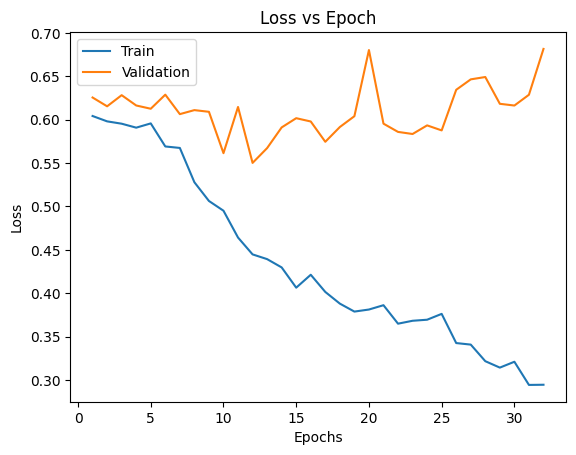

Loss: 0.2944158613681793
Val Loss: 0.6815958023071289


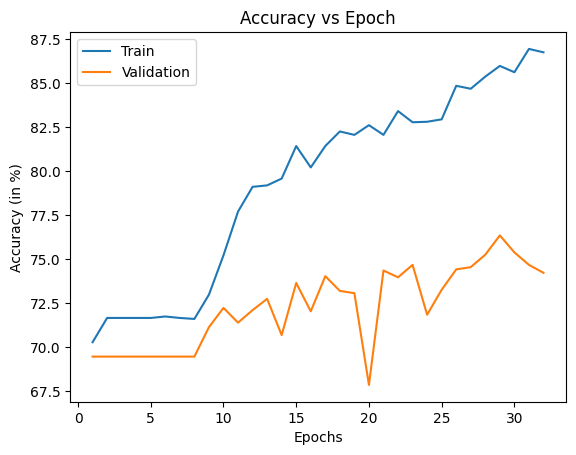

Accuracy: 0.8676795363426208
Val Accuracy: 0.7422680258750916


In [17]:
plot_history(history.history, num_of_epochs)

In [18]:
model.save('spam_detector_model')

INFO:tensorflow:Assets written to: spam_detector_model/assets


INFO:tensorflow:Assets written to: spam_detector_model/assets
